##### Copyright 2021 The Cirq Developers

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/qcvv/xeb_characterization_pipeline>"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/Cirq/blob/master/docs/qcvv/xeb_characterization_pipeline.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/Cirq/blob/master/docs/qcvv/xeb_characterization_pipeline.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/Cirq/docs/qcvv/xeb_characterization_pipeline.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

In [ ]:
try:
    import cirq
except ImportError:
    !pip install --quiet cirq
    import cirq
import numpy as np

     |████████████████████████████████| 541 kB 7.4 MB/s 
     |████████████████████████████████| 48 kB 2.6 MB/s 
     |████████████████████████████████| 593 kB 43.9 MB/s 
     |████████████████████████████████| 56 kB 3.0 MB/s 
     |████████████████████████████████| 1.8 MB 42.0 MB/s 
     |████████████████████████████████| 145 kB 43.9 MB/s 
     |████████████████████████████████| 10.1 MB 15.0 MB/s 
     |████████████████████████████████| 65 kB 2.6 MB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 
     |████████████████████████████████| 49 kB 5.2 MB/s 
     |████████████████████████████████| 220 kB 46.2 MB/s 
     |████████████████████████████████| 97 kB 5.4 MB/s 
     |████████████████████████████████| 52 kB 860 kB/s 
     |████████████████████████████████| 38.1 MB 29.9 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 229 kB 46.9 MB/s 
     |████████████████████████████████| 243 kB 50.5 MB/s 
     |███████████████████████

This notebook is a straightforward outline of how to characterize coherent error with [Cross Entropy Benchmarking (XEB)](./xeb_theory.ipynb). 

## Set up Random Circuits

Create a library of random, two-qubit `circuits` using the `SQRT_ISWAP` gate. These library circuits will be truncated by `cycle_depths` and mixed-and-matched among all the qubit pairs on the device to be characterized.

In [ ]:
from cirq.experiments import random_quantum_circuit_generation as rqcg

RANDOM_SEED = np.random.RandomState(53)
circuit_library = rqcg.generate_library_of_2q_circuits(
    n_library_circuits=20, 
    two_qubit_gate=cirq.SQRT_ISWAP,
    random_state=RANDOM_SEED,
)

20


In [ ]:
# Will truncate to these lengths
max_depth = 100
cycle_depths = np.arange(3, max_depth, 20)
cycle_depths

array([ 3, 23, 43, 63, 83])

## Determine the device topology

XEB can be run on all pairs from a given device topology. Below, you can supply a `device_name` if you're authenticated to run on Google QCS. That case will get the device object from the cloud endpoint and turn it into a graph of qubits. Otherwise, mock a device graph by allocating arbitrary `cirq.GridQubit`s into a graph.

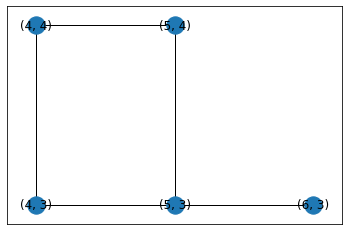

In [ ]:
device_name = None  # change me!

import networkx as nx
import itertools

if device_name is not None:
    import cirq_google as cg
    sampler = cg.get_engine_sampler(device_name, gate_set_name='sqrt_iswap')
    device = cg.get_engine_device(device_name)
    qubits = sorted(device.qubits)
else:
    qubits = cirq.GridQubit.rect(3, 2, 4, 3)
    # Delete one qubit from the rectangular arangement to
    # 1) make it irregular 2) simplify simulation.
    qubits = qubits[:-1]
    noise_model = cirq.ConstantQubitNoiseModel(cirq.depolarize(5e-3))
    sampler = cirq.DensityMatrixSimulator(noise=noise_model)

# create a graph from adjacent qubits and draw it
graph = nx.Graph((q1,q2) for (q1,q2) in itertools.combinations(qubits, r=2) if q1.is_adjacent(q2))
pos = {q: (q.row, q.col) for q in qubits}
nx.draw_networkx(graph, pos=pos)

## Set up qubit pair combinations
Take the library of two-qubit circuits in `circuit_library` and mix-and-match them in parallel into larger circuits which will be simulated and sampled. The `combs_by_layer` function defines the combinations of non-overlapping qubit pairs to be tested in parallel, with would-be overlapping pairs separated into different layers. Both `combs_by_layer` and the `circuit_library` will be passed to the sampling function, which zips the two configurations together to create each final circuit to be simulated. 

The outer list  of `combs_by_layer` corresponds to the multiple `cirq.CircuitLibraryCombination` objects, containing one `cirq.GridInteractionLayer`s each. Each inner `cirq.GridInteractionLayer`'s `combinations` matrix is an `(n_combinations, n_pairs)` ndarray of integers which index into the circuit library.

In [ ]:
parallel = True

if parallel:
  combs_by_layer = rqcg.get_random_combinations_for_device(
      n_library_circuits=len(circuit_library),
      n_combinations=10,
      device_graph=graph,
      random_state=53,
  )
else:
  layer_pairs = [[pair] for pair in graph.edges]
  combs_by_layer = rqcg.get_random_combinations_for_pairs(
      n_library_circuits=len(circuit_library), 
      n_combinations=10,
      all_pairs=layer_pairs,
      random_state=53,
  )
print(len(combs_by_layer))
combs_by_layer[0]

4


CircuitLibraryCombination(layer=cirq.experiments.GridInteractionLayer(col_offset=0, vertical=True, stagger=True), combinations=array([[ 5, 16],
       [12,  9],
       [ 5, 18],
       [11,  3],
       [ 6,  9],
       [13,  3],
       [11,  6],
       [14, 12],
       [16, 10],
       [18, 15]]), pairs=[(cirq.GridQubit(4, 4), cirq.GridQubit(5, 4)), (cirq.GridQubit(5, 3), cirq.GridQubit(6, 3))])

### Visualize
Here, draw the layers' active pairs to see which qubits will be tested in which layers.

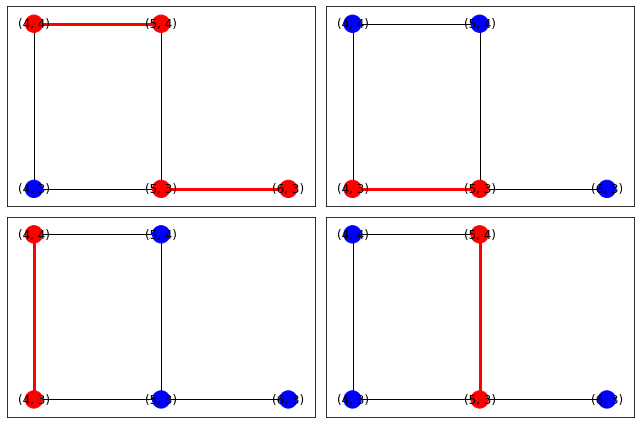

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

ncols = int(len(combs_by_layer)**(1/2))
nrows = ncols+1 if ncols**2 < len(combs_by_layer) else ncols
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(9,6))
for comb_layer, ax in zip(combs_by_layer, axes.reshape(-1)):
    active_qubits = np.array(comb_layer.pairs).reshape(-1)
    # highlight the active qubits in red
    colors = ['red' if q in active_qubits else 'blue' for q in graph.nodes]
    nx.draw_networkx(graph, pos=pos, node_color=colors, ax=ax)
    # highlight the active pair edges in red 
    nx.draw_networkx_edges(graph, pos=pos, edgelist=comb_layer.pairs, width=3, edge_color='red', ax=ax)
    
plt.tight_layout()

## Sample Data

The sampling function `sample_2q_xeb_circuits` zips the circuits of `circuit_library` together according to `combs_by_layer`, before sampling them and computing the sampled probabilities of getting the correct bit string `sampled_probs`. 

For layers with multiple active qubit pairs, it will combine the two-qubit circuits from `circuit_library` by placing different circuits on different active pairs. This creates larger, many-pair circuits, which operate on all the active pairs of a layer in parallel, without ever connecting the distinct pairs' circuits to each other. An inspection of one of the sampled `DataFrame`s reveals the available types of data, including the sampled probabilities `sampled_probs`.


In [ ]:
from cirq.experiments.xeb_sampling import sample_2q_xeb_circuits
sampled_df = sample_2q_xeb_circuits(
    sampler=sampler,
    circuits=circuit_library,
    cycle_depths=cycle_depths,
    combinations_by_layer=combs_by_layer,
    shuffle=np.random.RandomState(52),
    repetitions=10_000,
)
sampled_df.head()

100%|██████████| 207/207 [01:56<00:00,  1.78it/s]


,,sampled_probs,timestamp,layer_i,pair_i,combination_i,pair
circuit_i,cycle_depth,,,,,,
0,23,"[0.2641, 0.1152, 0.1477, 0.473]",1.649249e+09,1,0,6,"((4, 3), (5, 3))"
11,63,"[0.2263, 0.3163, 0.2433, 0.2141]",1.649249e+09,2,0,5,"((4, 3), (4, 4))"
3,43,"[0.1654, 0.2014, 0.2437, 0.3895]",1.649249e+09,1,0,1,"((4, 3), (5, 3))"
14,23,"[0.2681, 0.4596, 0.0942, 0.1781]",1.649249e+09,0,0,7,"((4, 4), (5, 4))"
12,23,"[0.1422, 0.4742, 0.2578, 0.1258]",1.649249e+09,0,1,7,"((5, 3), (6, 3))"


## Benchmark Fidelities

The `benchmark_2q_xeb_fidelities` function takes each sampled `DataFrame` and computes the overall fidelity across all of the randomized circuits for each qubit pair and each of the previously defined `cycle_depth`s.

In [ ]:
from cirq.experiments.xeb_fitting import benchmark_2q_xeb_fidelities
fids = benchmark_2q_xeb_fidelities(
    sampled_df=sampled_df,
    circuits=circuit_library,
    cycle_depths=cycle_depths,
)
fids.head()

,layer_i,pair_i,cycle_depth,fidelity,pair
0,0,0,3,0.923754,"((4, 4), (5, 4))"
1,0,0,23,0.609790,"((4, 4), (5, 4))"
2,0,0,43,0.388905,"((4, 4), (5, 4))"
3,0,0,63,0.273583,"((4, 4), (5, 4))"
4,0,0,83,0.164434,"((4, 4), (5, 4))"


## Estimate By-Layer Fidelities

Next, use `fit_exponential_decays` on each of the fidelity datasets of `circuit_fidelities`, to estimate a per-layer fidelity, which estimates the fidelity error of the two-qubit entangling gate operation on each individual qubit pair. 

In [ ]:
from cirq.experiments.xeb_fitting import fit_exponential_decays, exponential_decay
fidelities = fit_exponential_decays(fids)
fidelities.head()

a  layer_fid         cycle_depths  \
layer_i pair_i pair                                                         
0       0      ((4, 4), (5, 4))  0.984668   0.979148  [3, 23, 43, 63, 83]   
        1      ((5, 3), (6, 3))  0.989101   0.978924  [3, 23, 43, 63, 83]   
1       0      ((4, 3), (5, 3))  0.985579   0.979053  [3, 23, 43, 63, 83]   
2       0      ((4, 3), (4, 4))  0.987697   0.979172  [3, 23, 43, 63, 83]   
3       0      ((5, 3), (5, 4))  0.991141   0.978728  [3, 23, 43, 63, 83]   

                                                                        fidelities  \
layer_i pair_i pair                                                                  
0       0      ((4, 4), (5, 4))  [0.9237541611789994, 0.6097902851394199, 0.388...   
        1      ((5, 3), (6, 3))  [0.9258782284769331, 0.612354177488129, 0.3886...   
1       0      ((4, 3), (5, 3))  [0.9254068754933212, 0.6033366411211782, 0.398...   
2       0      ((4, 3), (4, 4))  [0.9256166497353442, 0.6113186097424644, 0.400...   
3       0      ((5, 3), (5, 4))  [0.9267472745801718, 0.6118721177336574, 0.385...   

                                    a_std  layer_fid_std  
layer_i pair_i pair                                       
0       0      ((4, 4), (5, 4))  0.010580       0.000411  
        1      ((5, 3), (6, 3))  0.007399       0.000289  
1       0      ((4, 3), (5, 3))  0.003748       0.000146  
2       0      ((4, 3), (4, 4))  0.004611       0.000178  
3       0      ((5, 3), (5, 4))  0.009081       0.000356

# Visualizations

Plot the fidelity decrease per layer by qubit in a heatmap to compare the different qubits.

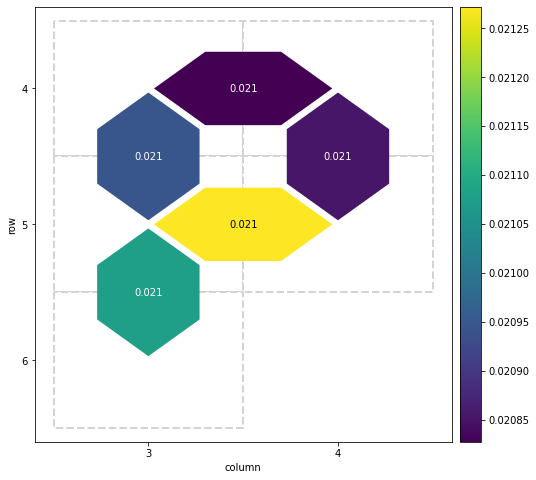

In [ ]:
heatmap_data = {}

for (_, _, pair), fidelity in fidelities.layer_fid.items():
    heatmap_data[pair] = 1.0 - fidelity

cirq.TwoQubitInteractionHeatmap(heatmap_data).plot();

Plot the fidelities by cycle depth with their fit exponential decay curves. 

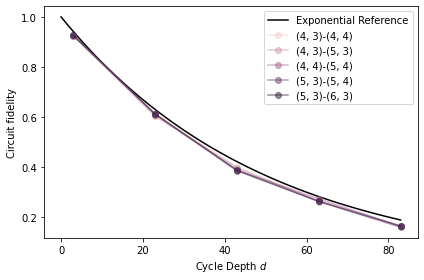

In [ ]:
import seaborn as sns

# Give each pair its own color
colors = sns.cubehelix_palette(n_colors=graph.number_of_edges())
colors = dict(zip(graph.edges, colors))

# Exponential reference
xx = np.linspace(0, fids['cycle_depth'].max())
plt.plot(xx, (1-5e-3)**(4*xx), label=r'Exponential Reference', color='black')

# Plot each pair
def _p(fids):
    q0, q1 = fids.name
    plt.plot(fids['cycle_depth'], fids['fidelity'], 
             'o-', label=f'{q0}-{q1}', color=colors[fids.name], alpha=0.5)

fids.groupby('pair').apply(_p)

plt.ylabel('Circuit fidelity')
plt.xlabel('Cycle Depth $d$')
plt.legend(loc='best')
plt.tight_layout()

## Optimize `PhasedFSimGate` parameters

In a real experiment, there is likely unknown coherent error that you would like to characterize. Therefore, make the five angles in `PhasedFSimGate` free parameters in `SqrtISwapXEBOptions`, and use a classical optimizer (`characterize_phased_fsim_parameters_with_xeb_py_pair`) to find out which set of parameters best describes the data collected from the noisy simulator (or device, if this was a real experiment).

In [ ]:
import multiprocessing
pool = multiprocessing.get_context('spawn').Pool()

In [ ]:
from cirq.experiments.xeb_fitting import (
    parameterize_circuit, 
    characterize_phased_fsim_parameters_with_xeb_by_pair, 
    SqrtISwapXEBOptions,
)

# Set which angles to characterize (all)
options = SqrtISwapXEBOptions(
    characterize_theta = True,
    characterize_zeta = True,
    characterize_chi = True,
    characterize_gamma = True,
    characterize_phi = True
)
# Parameterize the sqrt(iswap)s in the circuit library
pcircuits = [parameterize_circuit(circuit, options) for circuit in circuit_library]

# Run the characterization loop
characterization_result = characterize_phased_fsim_parameters_with_xeb_by_pair(
    sampled_df,
    pcircuits,
    cycle_depths,
    options,
    pool=pool,
    # ease tolerance so it converges faster:
    fatol=1e-2, 
    xatol=1e-2
)

The fitting procedure finds likely parameter values...

In [ ]:
characterization_result.final_params

{(cirq.GridQubit(4, 3), cirq.GridQubit(4, 4)): {'chi': -0.04327399218219708,
  'gamma': -0.03271468322885375,
  'phi': 0.0001627655585590736,
  'theta': -0.7947621797622686,
  'zeta': -0.037634441949985435},
 (cirq.GridQubit(4, 3), cirq.GridQubit(5, 3)): {'chi': -0.0009723008247123025,
  'gamma': 0.009792904316604187,
  'phi': 0.0274143878541546,
  'theta': -0.7687425678031369,
  'zeta': -0.06601541262301483},
 (cirq.GridQubit(4, 4), cirq.GridQubit(5, 4)): {'chi': 0.022235481633279108,
  'gamma': 0.01345914224127061,
  'phi': 0.005503195435523382,
  'theta': -0.7721337000160508,
  'zeta': -0.023470215296260973},
 (cirq.GridQubit(5, 3), cirq.GridQubit(5, 4)): {'chi': 0.00867832692660305,
  'gamma': 0.012630729693941092,
  'phi': -0.0011752059910234243,
  'theta': -0.7240514331184449,
  'zeta': 0.005824188971717952},
 (cirq.GridQubit(5, 3), cirq.GridQubit(6, 3)): {'chi': 0.08214368283946749,
  'gamma': -0.034485461992109986,
  'phi': 0.025055959109229996,
  'theta': -0.7913141401565346,


and refit fidelities. 

In [ ]:
characterization_result.fidelities_df.head()

,layer_i,pair_i,cycle_depth,fidelity,pair
0,1,0,3,0.934318,"((4, 3), (5, 3))"
1,1,0,23,0.583419,"((4, 3), (5, 3))"
2,1,0,43,0.446467,"((4, 3), (5, 3))"
3,1,0,63,0.293871,"((4, 3), (5, 3))"
4,1,0,83,0.160441,"((4, 3), (5, 3))"


The `before_and_after_characterization` function collects the before fidelities, `circuit_fidelities`, and the after fidelities, `characterization_results` into the same data frame, by row, suffixing the data by source with `_0` and `_c` respectively. 

In [ ]:
from cirq.experiments.xeb_fitting import before_and_after_characterization
before_after_df = before_and_after_characterization(fids, characterization_result)
before_after_df.head()

,layer_i,pair_i,a_0,layer_fid_0,cycle_depths_0,fidelities_0,a_std_0,layer_fid_std_0,a_c,layer_fid_c,cycle_depths_c,fidelities_c,a_std_c,layer_fid_std_c,characterized_angles,theta,zeta,chi,gamma,phi
pair,,,,,,,,,,,,,,,,,,,,
"((4, 4), (5, 4))",0,0,0.984668,0.979148,"[3, 23, 43, 63, 83]","[0.9237541611789994, 0.6097902851394199, 0.388...",0.010580,0.000411,0.996989,0.978977,"[3, 23, 43, 63, 83]","[0.9262671056207218, 0.6230496642722564, 0.422...",0.022327,0.000862,"{'theta': -0.7721337000160508, 'zeta': -0.0234...",-0.772134,-0.023470,0.022235,0.013459,0.005503
"((5, 3), (6, 3))",0,1,0.989101,0.978924,"[3, 23, 43, 63, 83]","[0.9258782284769331, 0.612354177488129, 0.3886...",0.007399,0.000289,1.000000,0.979570,"[3, 23, 43, 63, 83]","[0.9735288620002522, 0.6099515911914576, 0.391...",0.027817,0.001049,"{'theta': -0.7913141401565346, 'zeta': -0.0636...",-0.791314,-0.063639,0.082144,-0.034485,0.025056
"((4, 3), (5, 3))",1,0,0.985579,0.979053,"[3, 23, 43, 63, 83]","[0.9254068754933212, 0.6033366411211782, 0.398...",0.003748,0.000146,0.982389,0.980116,"[3, 23, 43, 63, 83]","[0.9343175860729899, 0.5834185591646901, 0.446...",0.034976,0.001316,"{'theta': -0.7687425678031369, 'zeta': -0.0660...",-0.768743,-0.066015,-0.000972,0.009793,0.027414
"((4, 3), (4, 4))",2,0,0.987697,0.979172,"[3, 23, 43, 63, 83]","[0.9256166497353442, 0.6113186097424644, 0.400...",0.004611,0.000178,1.000000,0.979310,"[3, 23, 43, 63, 83]","[0.9546454681822227, 0.6347331347198645, 0.398...",0.019438,0.000740,"{'theta': -0.7947621797622686, 'zeta': -0.0376...",-0.794762,-0.037634,-0.043274,-0.032715,0.000163
"((5, 3), (5, 4))",3,0,0.991141,0.978728,"[3, 23, 43, 63, 83]","[0.9267472745801718, 0.6118721177336574, 0.385...",0.009081,0.000356,0.974520,0.981029,"[3, 23, 43, 63, 83]","[0.9311439125569454, 0.584442776962492, 0.4707...",0.040617,0.001491,"{'theta': -0.7240514331184449, 'zeta': 0.00582...",-0.724051,0.005824,0.008678,0.012631,-0.001175


Plot the original fidelities with the refit ones found by the parameter fitting. 

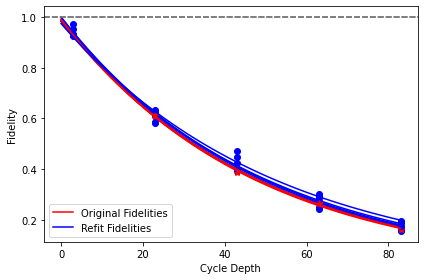

In [ ]:
for i, row in before_after_df.iterrows():
    plt.axhline(1, color='grey', ls='--')
    plt.plot(row['cycle_depths_0'], row['fidelities_0'], '*', color='red')
    plt.plot(row['cycle_depths_c'], row['fidelities_c'], 'o', color='blue')

    xx = np.linspace(0, np.max(row['cycle_depths_0']))
    plt.plot(xx, exponential_decay(xx, a=row['a_0'], layer_fid=row['layer_fid_0']), color='red', label='Original Fidelities')
    plt.plot(xx, exponential_decay(xx, a=row['a_c'], layer_fid=row['layer_fid_c']), color='blue', label='Refit Fidelities')
    
    plt.xlabel('Cycle Depth')
    plt.ylabel('Fidelity')

# make the legend labels unique
handles, labels = plt.gca().get_legend_handles_labels()
legend_items = dict(zip(labels, handles))
plt.legend(legend_items.values(), legend_items.keys(), loc='best')
plt.tight_layout()
plt.show()